Let the RK45 solver decide how many points we should have and then, evaluate the solution

In [1]:
import scipy.integrate as integrate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, lstsq, norm
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model

In [2]:
#some most useful functions for data generations are now in scripts/mechanisms.py 
import sys
sys.path.insert(1, 'scripts/')
import scripts.mechanisms as mechanisms
import scripts.ls_solvers as solvers

In [3]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams.update({'font.size': 19})

In [4]:
constants = [1, 1, 1, 0]

In [5]:
k1, k_1, k2, k_2 = constants
W0 = np.array([[0, 0, 0, k_1, 0, -k1, 0,    0, 0, 0,  0,    0, 0, 0  ],
               [0, 0, 0, k2,      0, 0,   -k_2, 0, 0, 0,  0,    0, 0, 0 ],
               [0, 0, 0, k2+k_1,  0, -k1, -k_2, 0, 0, 0, 0,    0, 0, 0  ],
               [0, 0, 0, -k2-k_1, 0,  k1,  k_2, 0, 0, 0, 0,    0, 0, 0  ]])
W0.shape

(4, 14)

In [6]:
#initial values
U0 = np.array([1.0, 0.0, 0.1, 0.0])
# U0 = np.vstack((U0, [1.0, 0.0, 0.15, 0.0]))
# U0 = np.vstack((U0, [1.0, 0.0, 0.05, 0.0]))

In [7]:
# if we have only one initial condition
U0 = U0.reshape((1,4))

In [8]:
integration = 'RK45'
differentiation = 'spline'
#differentiation = 'fdm'
rtol = 1e-6

In [9]:
# increase time 
X, T, Y = mechanisms.find_solutions(U0, constants, 'A1r', differentiation, 100, rtol, integration) # checked fine

RK45


No handles with labels found to put in legend.


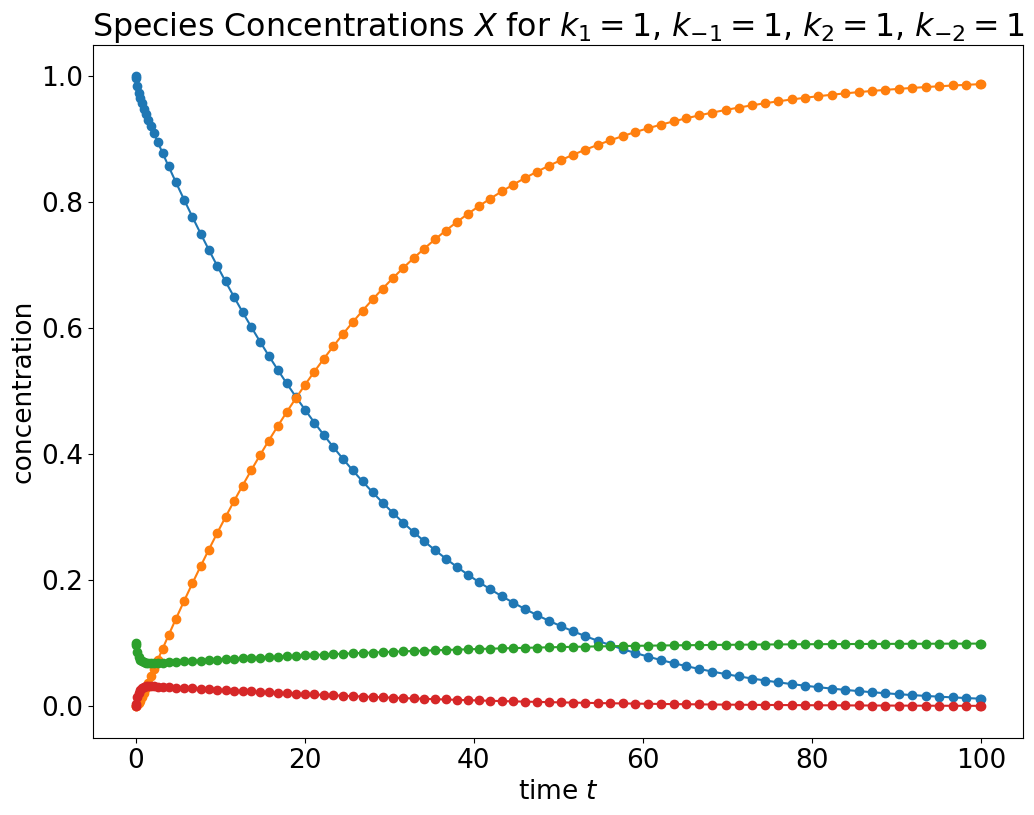

In [10]:
mechanisms.plot_concentrations(T, X, 'A1r')
plt.title('Species Concentrations $X$ for $k_1 = 1$, $k_{-1} = 1$, $k_2 = 1$, $k_{-2} = 1$')
plt.legend().set_visible(False)
plt.savefig('demo.png', transparent=True)

In [11]:
tolerances = []
number_of_points = []

for i in range(1, 10):
    rtol = 10 ** (-i)
    tolerances.append(rtol)
    X, T, Y = mechanisms.find_solutions(U0, constants, 'A1r', differentiation, 100, rtol, integration) 
    points, _ = X.shape
    number_of_points.append(points)

RK45
RK45
RK45
RK45
RK45
RK45
RK45
RK45
RK45


Text(0.5, 1.0, 'Number of time points vs error tolerance of RK45')

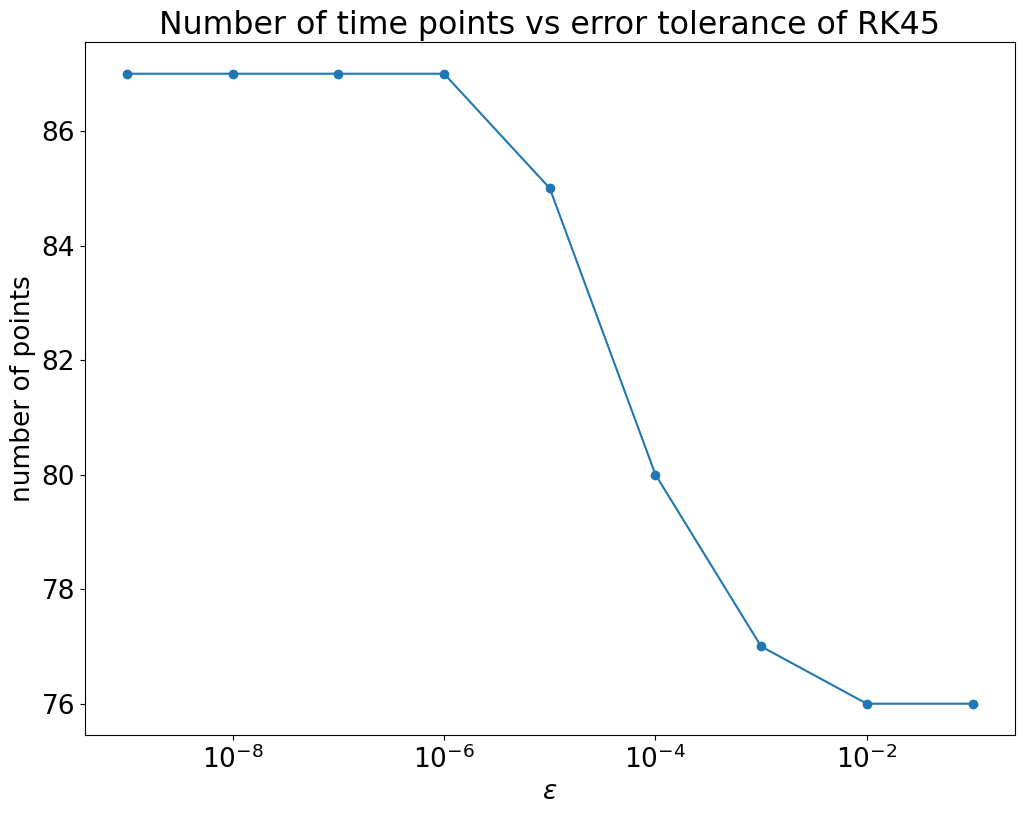

In [12]:
plt.plot(tolerances, number_of_points, '-o')
plt.xscale('log')
plt.xlabel('$\epsilon$')
plt.ylabel('number of points')
plt.title('Number of time points vs error tolerance of RK45')

In [13]:
X.shape

(87, 4)

In [14]:
Y_gt = mechanisms.ode(T, X.T, constants, 'A1r').T

<function matplotlib.pyplot.show(*args, **kw)>

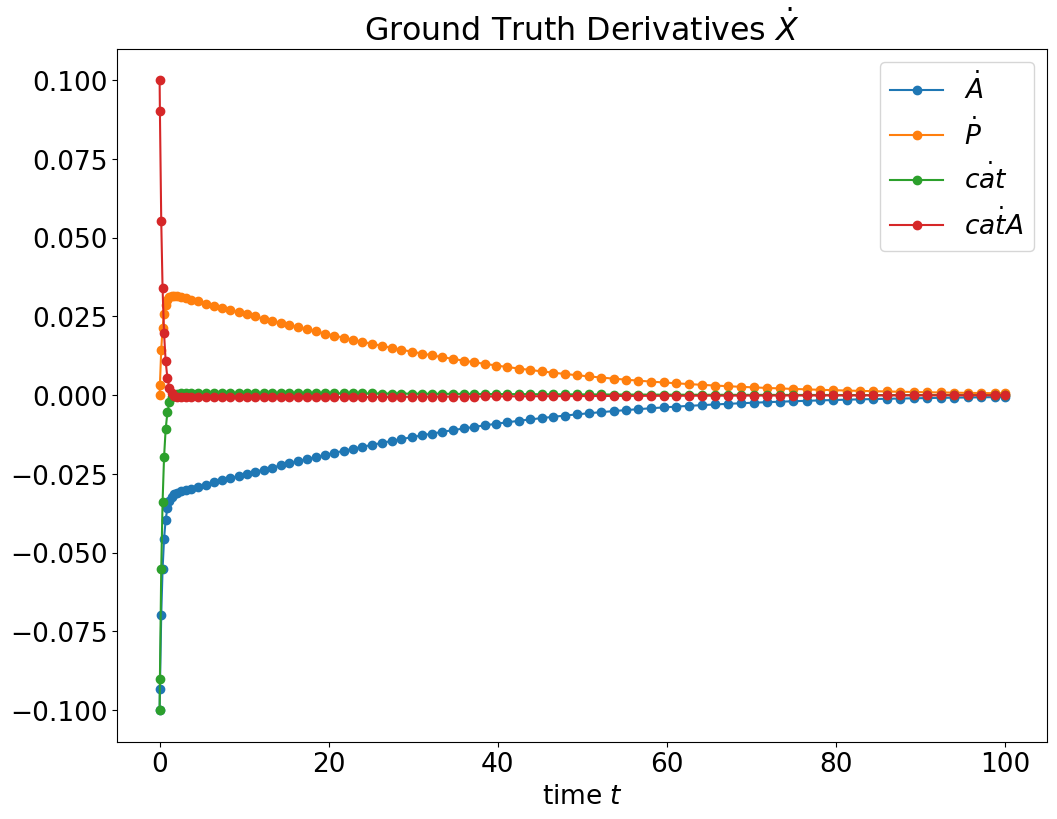

In [15]:
mechanisms.plot_derivatives(T, Y_gt, 'A1r')
plt.title('Ground Truth Derivatives $\dot{X}$')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

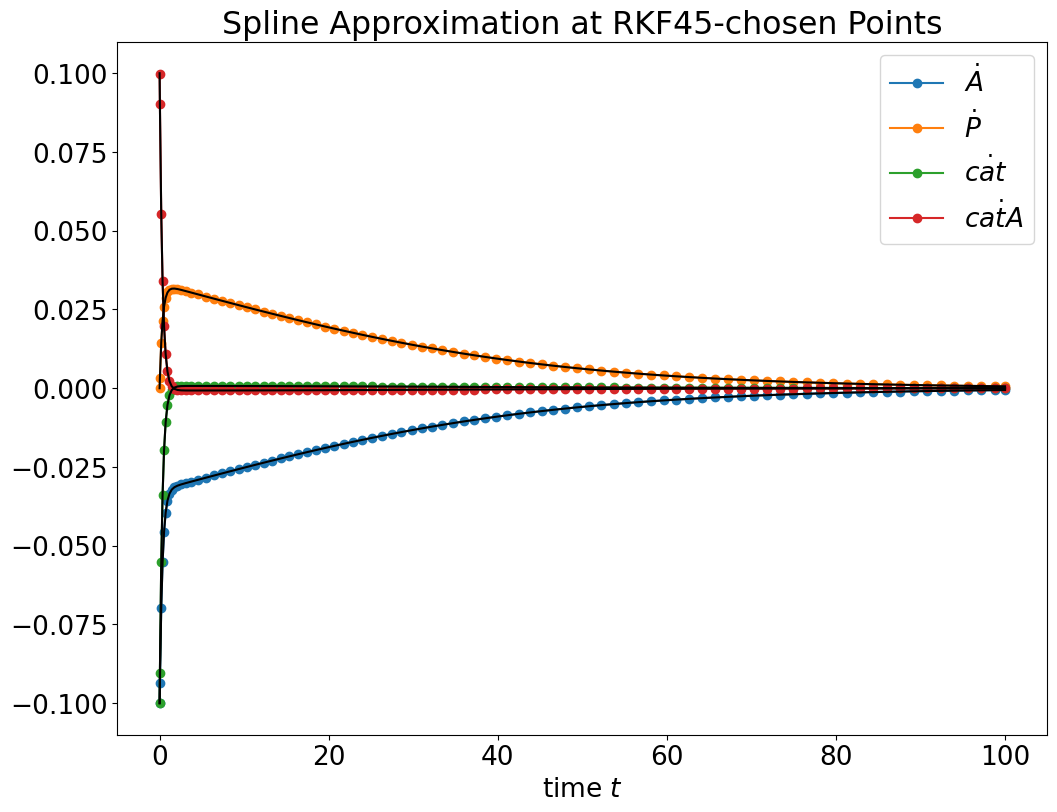

In [16]:
mechanisms.plot_derivatives(T, Y, 'A1r')
plt.plot(T, Y_gt, "-k")
plt.title('Spline Approximation at RKF45-chosen Points')
plt.show

In [17]:
mechanisms.get_residual(Y, Y_gt)

absolute residual 0.0002723289224105873
relative residual 0.0007818405762923797


(0.0002723289224105873, 0.0007818405762923797)

## Basic LS solver 

Our first test is to solve the above least squares problem as is, that is, without any regularisation or sparsity promoting terms. Note that minimizing the Frobenius norm over matrices in this problem is the same as solving $d$ ordinary least squares problem for each column of $Y$ and $Y'$. So we can just solve them one after another to get the coefficients for each of the $d$ equations.

As can be seen, this leads to a dense solution (all coeffs are nonzero). We can also check the relative residual of the solution to get some idea about the noise level. Note the residual is relatively large (close to 1 percent) and I think this is due to the numerical differentiation.

Creating $[n\times m]$ features matrix $\widetilde{X}$ 

In [18]:
X_tilde, labels = mechanisms.get_features(X, 'A1r', square=True)

added squared terms
X_tilde features matrix shape:  (87, 14)
labels:  ['A', 'P', 'cat', 'catA', 'P*A', 'cat*A', 'cat*P', 'catA*A', 'catA*P', 'catA*cat', 'A*A', 'P*P', 'cat*cat', 'catA*catA']


In [19]:
W_lsq = solvers.lsq(X_tilde, Y)


equation #0
relative residual 0.0004811549483780293
coefficients [ 0.15745218 -0.00771499 -0.47697427  0.54660888 -0.10796543 -0.41736736
 -0.04119641  0.43311257  0.04042491 -0.01841051 -0.16769496  0.05982553
 -0.02928692  0.0730714 ]

equation #1
relative residual 0.00032181575043602255
coefficients [ 0.06979451  0.0701736  -0.35796635  0.4132924  -0.043925   -0.12851716
 -0.12918384  0.13549661  0.1362012  -0.10026535 -0.0217771  -0.02210261
  0.06446871  0.14159459]

equation #2
relative residual 0.0010515292891839264
coefficients [ 0.22724669  0.06245861 -0.83494062  0.95990128 -0.15189043 -0.54588451
 -0.17038025  0.56860918  0.17662611 -0.11867586 -0.18947206  0.03772292
  0.0351818   0.21466599]

equation #3
relative residual 0.0010515292891828331
coefficients [-0.22724669 -0.06245861  0.83494062 -0.95990128  0.15189043  0.54588451
  0.17038025 -0.56860918 -0.17662611  0.11867586  0.18947206 -0.03772292
 -0.0351818  -0.21466599]


In [20]:
s = mechanisms.print_equation(labels, W_lsq, 1e-6)
equations = mechanisms.string_equation(labels, W_lsq, 1e-6) 

+0.16[A]-0.01[P]-0.48[cat]+0.55[catA]-0.11[P*A]-0.42[cat*A]-0.04[cat*P]+0.43[catA*A]+0.04[catA*P]-0.02[catA*cat]-0.17[A*A]+0.06[P*P]-0.03[cat*cat]+0.07[catA*catA]
______
+0.07[A]+0.07[P]-0.36[cat]+0.41[catA]-0.04[P*A]-0.13[cat*A]-0.13[cat*P]+0.14[catA*A]+0.14[catA*P]-0.10[catA*cat]-0.02[A*A]-0.02[P*P]+0.06[cat*cat]+0.14[catA*catA]
______
+0.23[A]+0.06[P]-0.83[cat]+0.96[catA]-0.15[P*A]-0.55[cat*A]-0.17[cat*P]+0.57[catA*A]+0.18[catA*P]-0.12[catA*cat]-0.19[A*A]+0.04[P*P]+0.04[cat*cat]+0.21[catA*catA]
______
-0.23[A]-0.06[P]+0.83[cat]-0.96[catA]+0.15[P*A]+0.55[cat*A]+0.17[cat*P]-0.57[catA*A]-0.18[catA*P]+0.12[catA*cat]+0.19[A*A]-0.04[P*P]-0.04[cat*cat]-0.21[catA*catA]
______
sparsity: 56
+0.15745218071554537*A-0.007714991395425391*P-0.4769742747624101*cat+0.5466088818827025*catA-0.10796543008426497*P*A-0.41736735501400823*cat*A-0.04119641097009249*cat*P+0.4331125730855646*catA*A+0.040424911830545585*catA*P-0.018410508778317465*catA*cat-0.1676949622857215*A*A+0.0598255268582929*P*P-0.029286

now knowing the equations we find the solutions for equispaced points

In [21]:
npts = T.shape[0]
npts

87

In [22]:
tmax = 100

In [24]:
# X_lsq, T_lsq, Y_lsq = mechanisms.data_from_equations(U0, constants, 'A1r',
#                                                      equations, differentiation, 100,
#                                                      rtol, integration, t_eq)

X_lsq, T_lsq, Y_lsq = mechanisms.data_from_equations(U0, constants, 'A1r',
                                                     equations, differentiation, 100,
                                                     rtol, integration, sorted(T))

In [25]:
Y_lsq.shape

(87, 4)

In [26]:
Y_gt.shape

(87, 4)

In [27]:
_, er_y = mechanisms.get_residual(Y_lsq, Y)
_, er_gt = mechanisms.get_residual(Y_lsq, Y_gt)
_, er_x = mechanisms.get_residual(X_lsq, X)
_, er_w = mechanisms.get_residual(W_lsq, W0)

table = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['basic least squares'])

absolute residual 0.0002790433398696708
relative residual 0.0008009400955933983
absolute residual 3.620824981973903e-05
relative residual 0.00010392879860682711
absolute residual 1.3719179104873304e-05
relative residual 1.684598297284646e-06
absolute residual 2.592235431208592
relative residual 1.0297543001333407


In [28]:
table

,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56


## Sequential Thresholded Least Squares

In [29]:
t_eval = 100

In [30]:
alpha = 0.5
W_stlsq = solvers.stlsq(X_tilde, Y, alpha)   
s = mechanisms.print_equation(labels, W_stlsq, 1e-2)
equations = mechanisms.string_equation(labels, W_stlsq, 1e-5)
X_stlsq, T_stlsq, Y_stlsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, t_eval, rtol, integration, T)

-1.10[catA]
______

______
+2.00[catA]-1.00[cat*A]
______
-2.00[catA]+1.00[cat*A]
______
sparsity: 5
-1.0989024806338163*catA
______

______
+1.999383634328509*catA-0.9996517468530608*cat*A
______
-1.9993836343285218*catA+0.9996517468530668*cat*A
______


In [31]:
X_stlsq.shape

(87, 4)

In [32]:
_, er_y = mechanisms.get_residual(Y_stlsq, Y)
_, er_gt = mechanisms.get_residual(Y_stlsq, Y_gt)
_, er_x = mechanisms.get_residual(X_stlsq, X)
_, er_w = mechanisms.get_residual(W_stlsq, W0)

row =  pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['STLSQ ' +  '$\alpha$' + '=' + str(alpha)])
table = table.append(row)
table

absolute residual 0.012796209326335477
relative residual 0.03679572868825953
absolute residual 0.012787978335847626
relative residual 0.036772060327958225
absolute residual 6.642505639952137
relative residual 1.4107654839808883
absolute residual 2.5308877149301936
relative residual 0.7562046898653215


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56
STLSQ $lpha$=0.5,0.036796,0.036772,1.410765,0.756205,5


In [33]:
alpha = 0.4
W_stlsq = solvers.stlsq(X_tilde, Y, alpha)   
s = mechanisms.print_equation(labels, W_stlsq, 1e-2)
equations = mechanisms.string_equation(labels, W_stlsq, 1e-5)
X_stlsq, T_stlsq, Y_stlsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, t_eval, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_stlsq, Y)
_, er_gt = mechanisms.get_residual(Y_stlsq, Y_gt)
_, er_x = mechanisms.get_residual(X_stlsq, X)
_, er_w = mechanisms.get_residual(W_stlsq, W0)

row =  pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['STLSQ, $\alpha$ = ' + str(alpha)])
table = table.append(row)
table

+1.00[catA]-1.00[cat*A]
______
+1.00[catA]
______
+2.00[catA]-1.00[cat*A]
______
-2.00[catA]+1.00[cat*A]
______
sparsity: 7
+0.9995689074031129*catA-0.9997596703023619*cat*A
______
+1.0000412556374298*catA
______
+1.999383634328509*catA-0.9996517468530608*cat*A
______
-1.9993836343285218*catA+0.9996517468530668*cat*A
______
absolute residual 0.00028187260480355475
relative residual 0.0008090514741985567
absolute residual 4.485236805669346e-05
relative residual 0.00012873856444067764
absolute residual 6.68630075286671e-05
relative residual 8.210157149041062e-06
absolute residual 0.001116993737202094
relative residual 0.0003098887163052354


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56
STLSQ $lpha$=0.5,0.036796,0.036772,1.410765,0.756205,5
"STLSQ, $lpha$ = 0.4",0.000809,0.000129,0.000008,0.000310,7


In [34]:
Y_stlsq.shape

(87, 4)

In [35]:
W_stlsq.shape

(4, 14)

In [36]:
# mechanisms.print_equation(labels, W_stlsq, 1e-5)

In [37]:
#alphas = np.linspace(0.0, 10, 200)
alphas = np.logspace(-2, 0, 10)
W_stlsq_arr = []
for alpha in alphas: 
    w = solvers.stlsq(X_tilde, Y, alpha)  
    W_stlsq_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]$ using STLSQ')

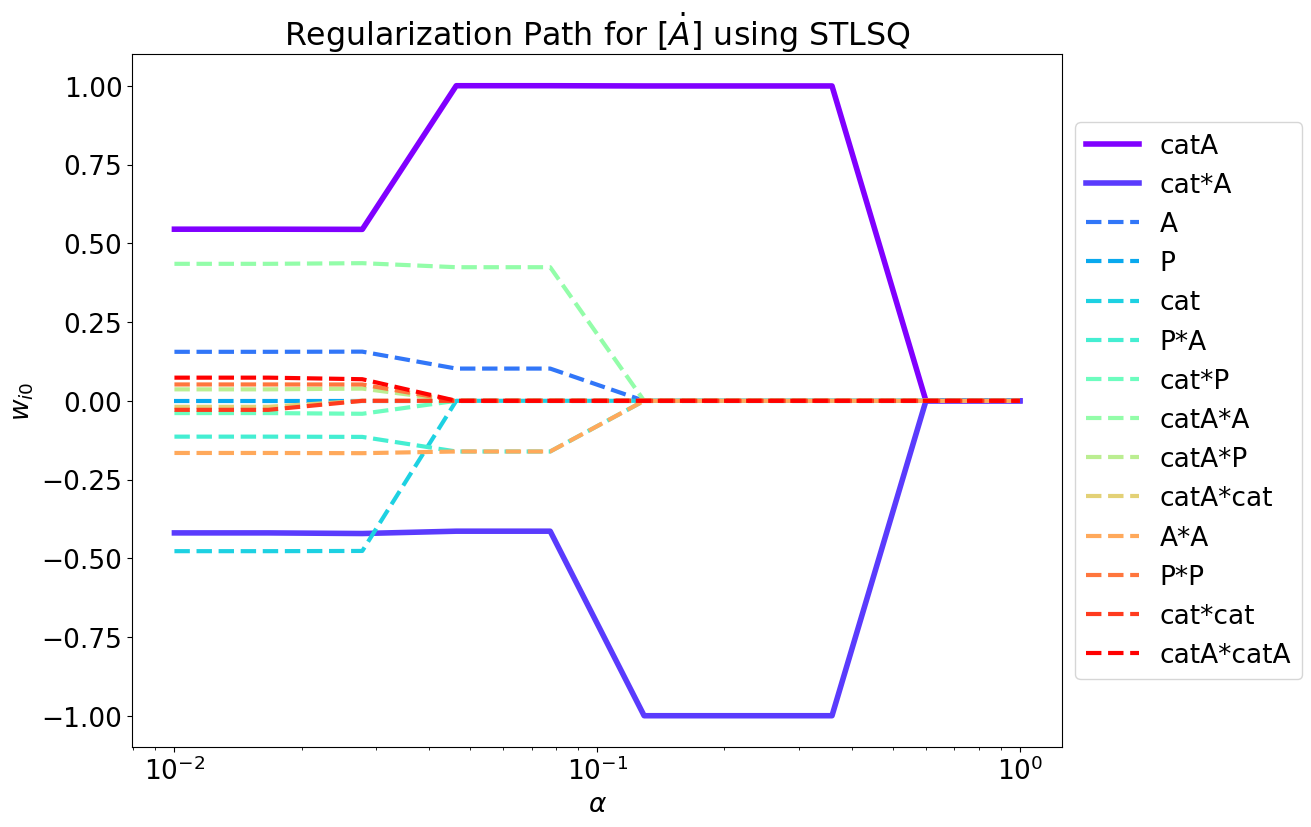

In [38]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 0, labels)
plt.title("Regularization Path for $[\dot{A}]$ using STLSQ")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]$ using STLSQ')

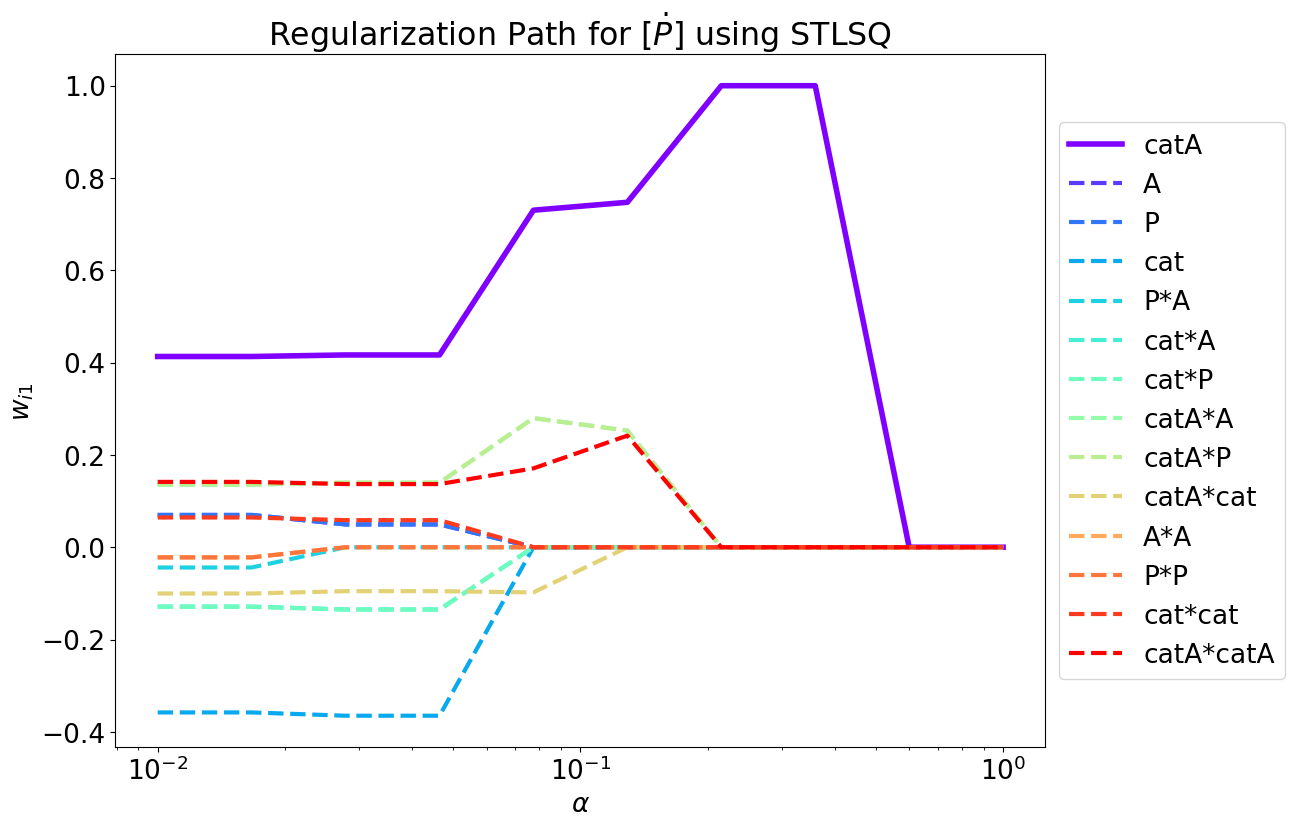

In [39]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 1, labels)
plt.title("Regularization Path for $[\dot{P}]$ using STLSQ")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ using STLSQ')

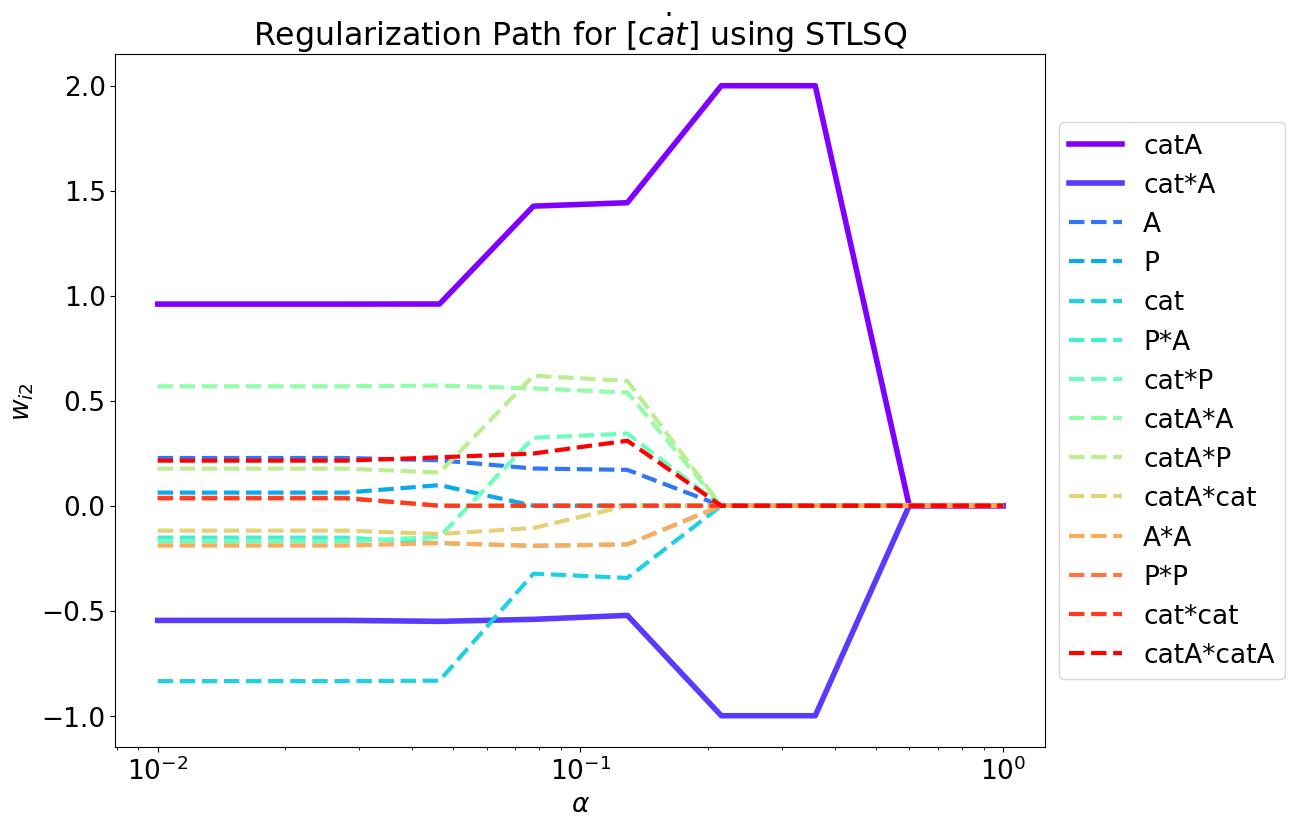

In [40]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 2, labels)
plt.title("Regularization Path for $[\dot{cat}]$ using STLSQ")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ using STLSQ')

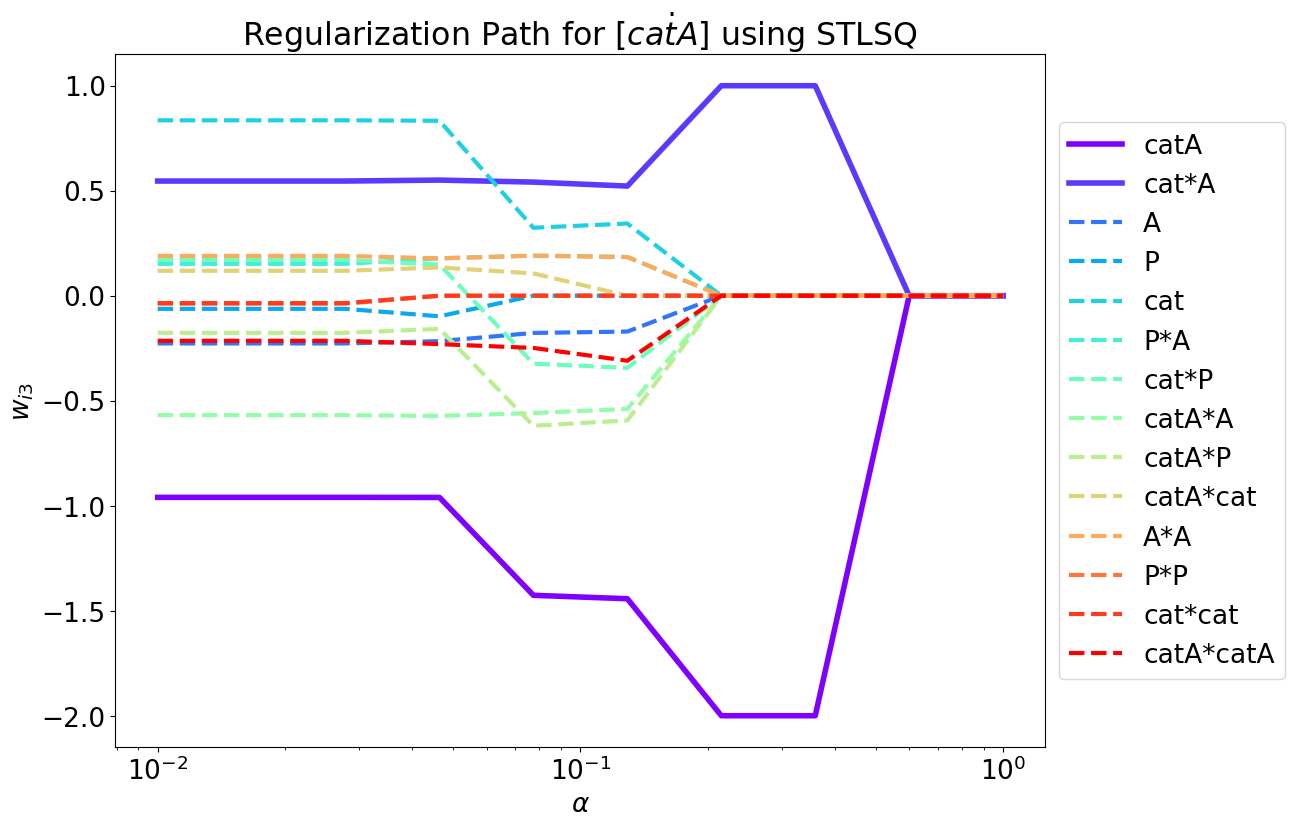

In [41]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 3, labels)
plt.title("Regularization Path for $[\dot{catA}]$ using STLSQ")

# Lasso CVXPY

In [42]:
lambdas = np.logspace(-5, 0, 10)
W_lasso_arr = []
for lambd in lambdas: 
    w = solvers.lasso_cvxp(X_tilde, Y, lambd)  
    W_lasso_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]$ using Lasso')

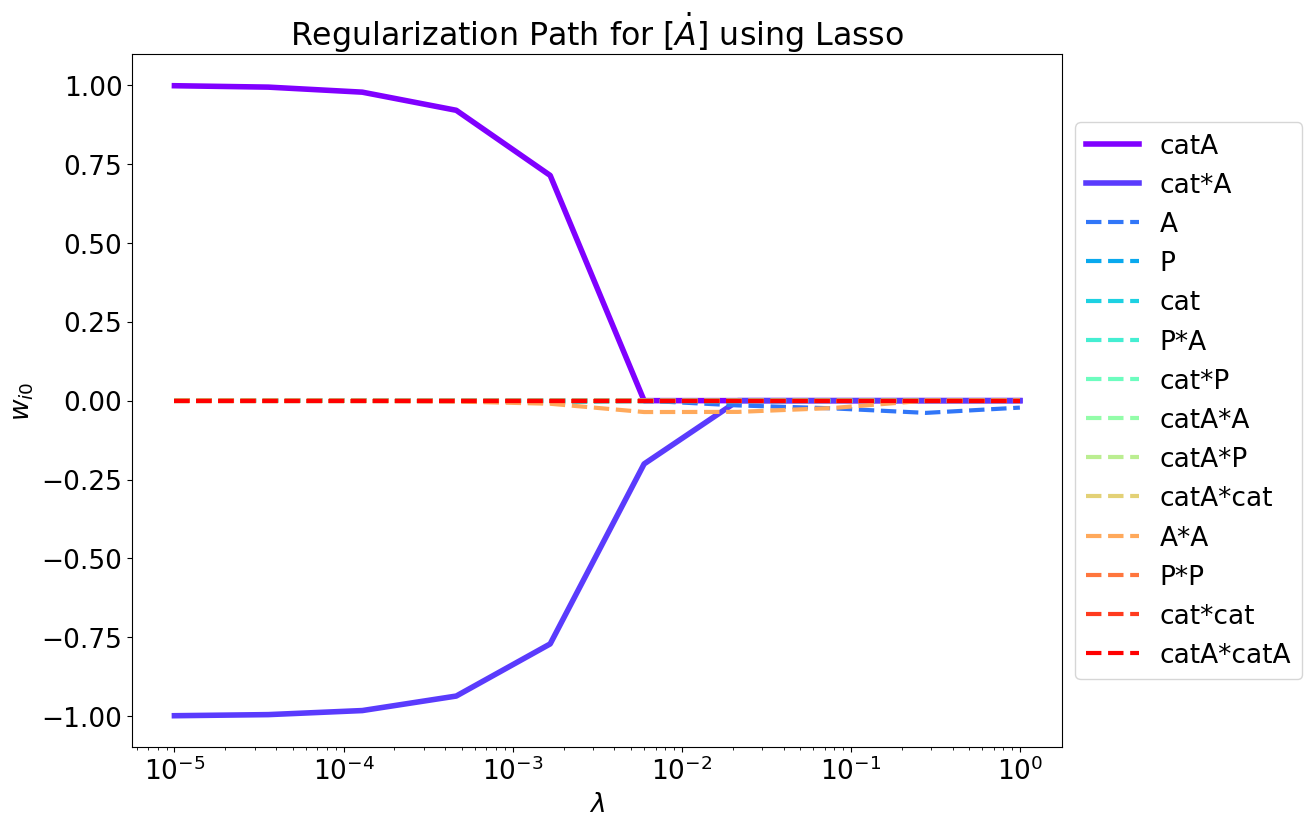

In [43]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 0, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{A}]$ using Lasso")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]$ using Lasso')

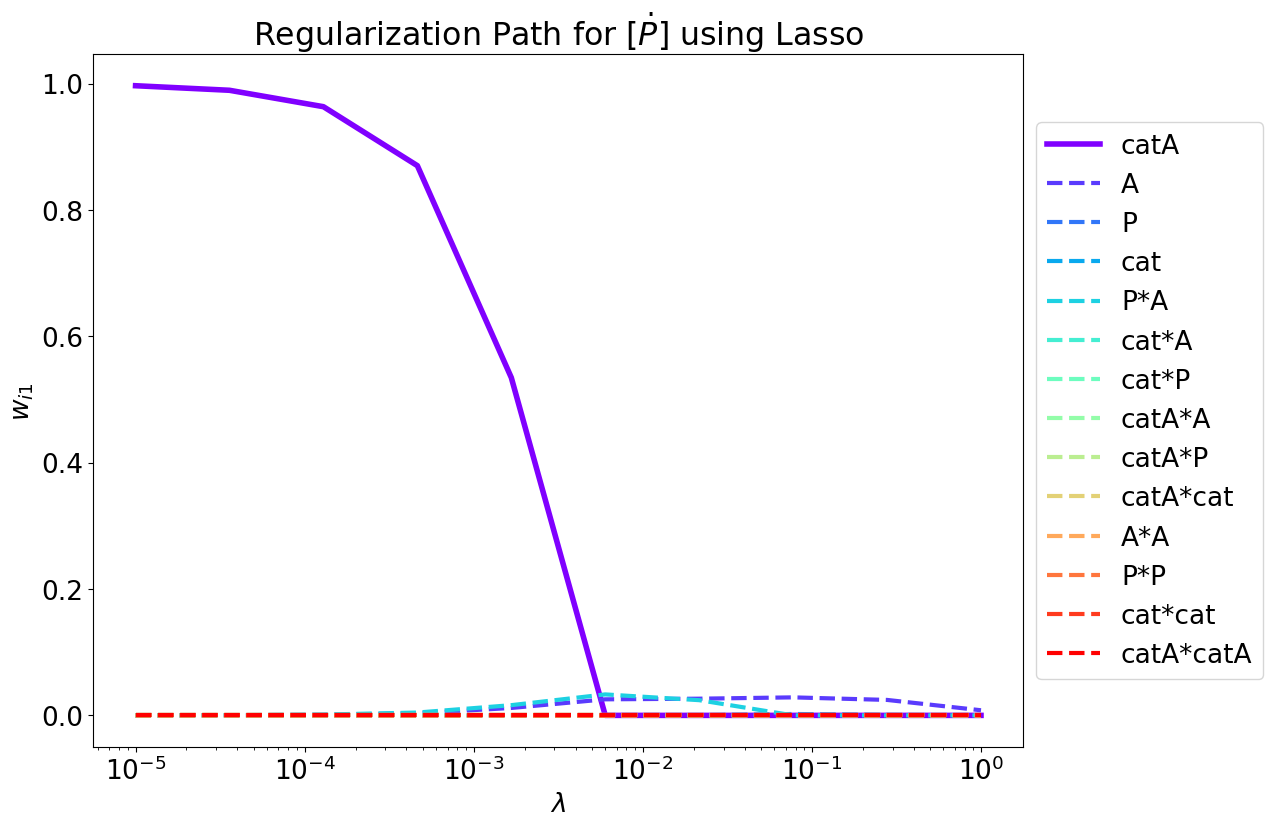

In [44]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 1, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{P}]$ using Lasso")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ using Lasso')

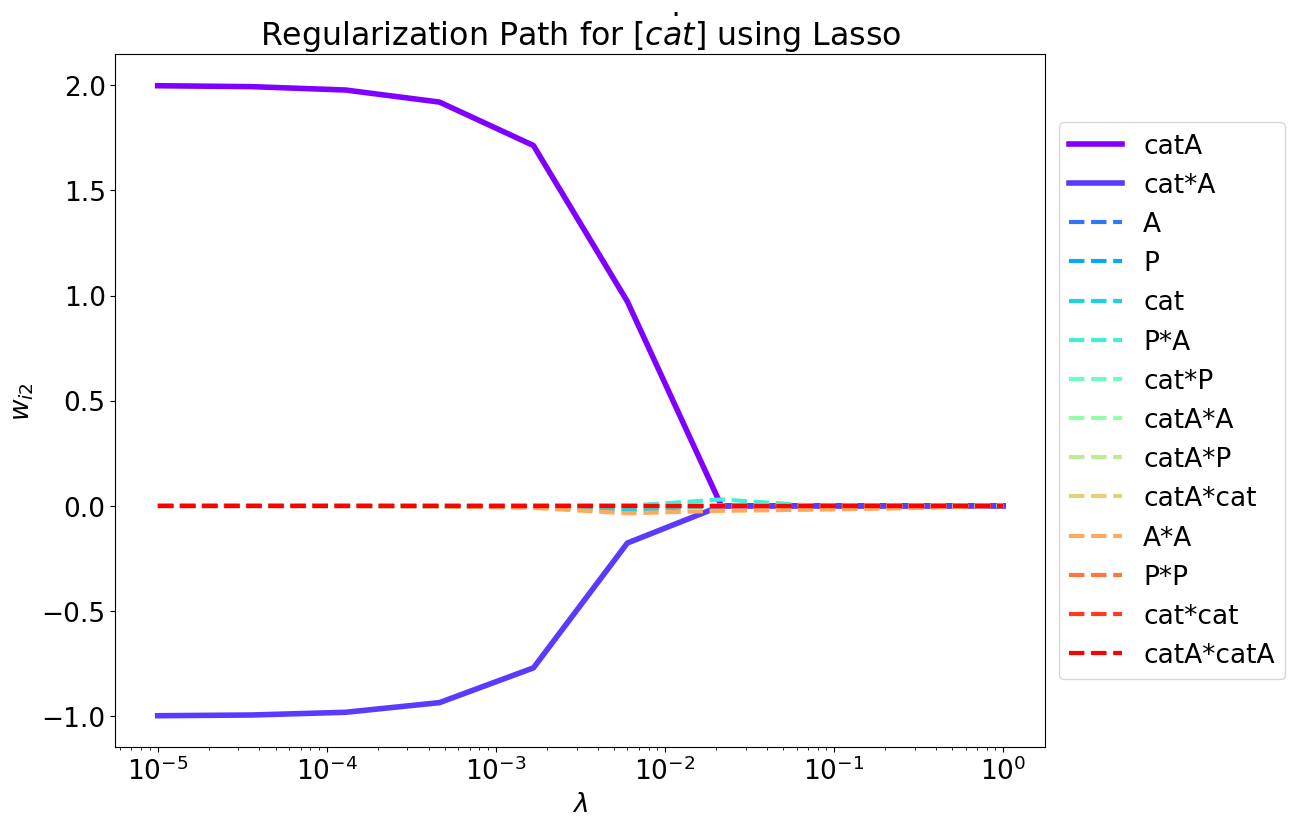

In [45]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 2, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{cat}]$ using Lasso")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ using Lasso')

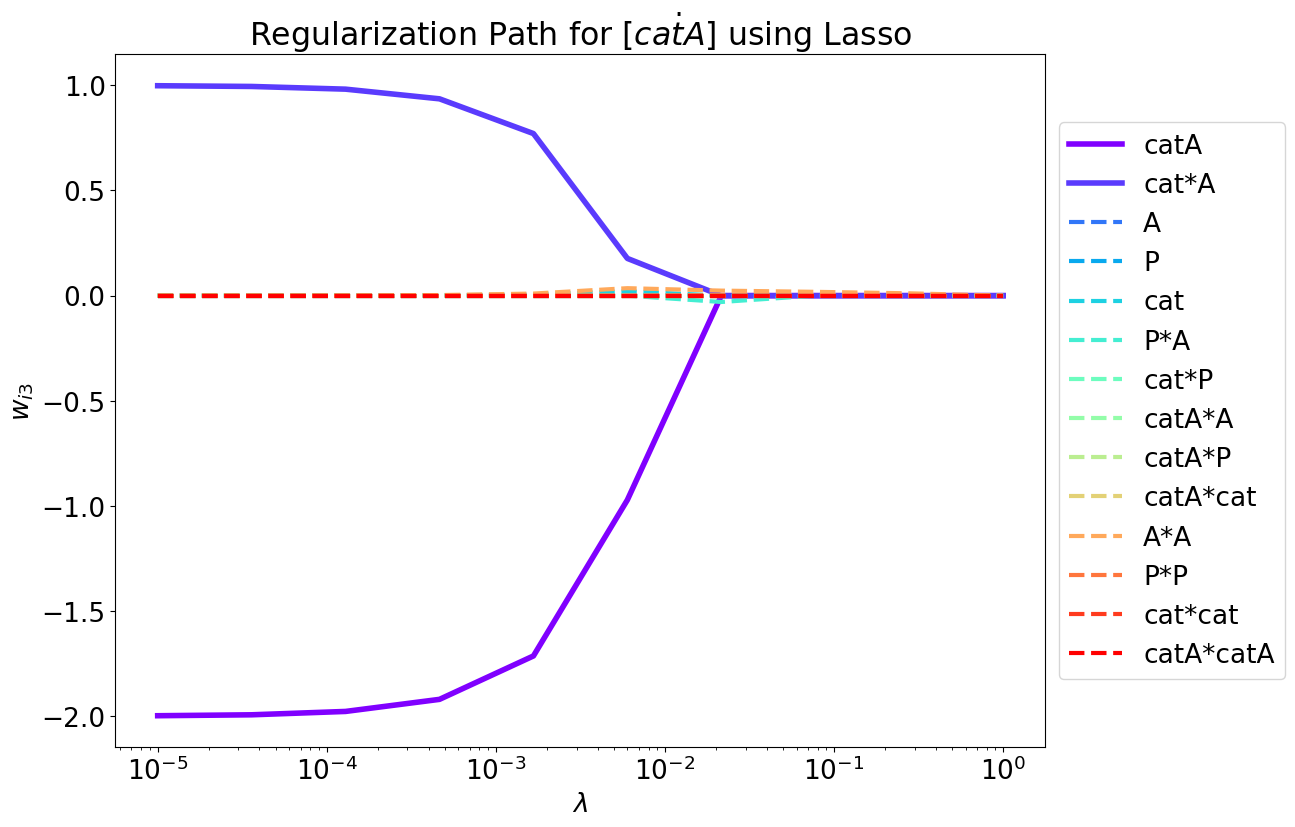

In [46]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 3, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{catA}]$ using Lasso")

In [47]:
lambd = 1e-5
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, t_eval, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

+1.00[catA]-1.00[cat*A]
______
+1.00[catA]
______
+2.00[catA]-1.00[cat*A]
______
-2.00[catA]+1.00[cat*A]
______
sparsity: 7
-1.7087474460347913e-05*cat+0.9978059535091982*catA-0.9983781224376348*cat*A+2.7172449609065026e-05*catA*A-6.124314720785728e-05*A*A
______
+8.209391638069689e-05*A+0.9968883285862767*catA+0.00010251143031818466*P*A
______
-1.0205524681940493e-05*cat+1.9975833351788048*catA-0.9982466016575171*cat*A+7.089983604401844e-05*catA*A-6.412259446881661e-05*A*A
______
+1.0201976150266102e-05*cat-1.9975829654130064*catA+0.9982464491155596*cat*A-7.140965687690223e-05*catA*A+6.413849598261587e-05*A*A
______
absolute residual 0.0003111317455952786
relative residual 0.0008929932513731744
absolute residual 0.00013013028544120735
relative residual 0.00037349279957251145
absolute residual 0.00045295378384127853
relative residual 5.562046044989496e-05
absolute residual 0.005916006831662943
relative residual 0.001643345938661069


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56
STLSQ $lpha$=0.5,0.036796,0.036772,1.410765,0.756205,5
"STLSQ, $lpha$ = 0.4",0.000809,0.000129,0.000008,0.000310,7
"Lasso_cvxp, $\lambda$ = 1e-05",0.000893,0.000373,0.000056,0.001643,7


In [48]:
lambd = 1e-4
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, t_eval, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

+0.98[catA]-0.99[cat*A]
______
+0.97[catA]
______
+1.98[catA]-0.99[cat*A]
______
-1.98[catA]+0.99[cat*A]
______
sparsity: 7
-0.0003325019656747441*cat+0.9823944823345282*catA-0.9860313879363933*cat*A+1.1292826784651668e-05*catA*A-0.0005943001307029707*A*A
______
+0.0007152963610992555*A+0.9718075365688862*catA+0.0009745060558784143*P*A-1.9396784677099246e-05*P*P
______
-0.0003246494795936817*cat+1.9821886314747639*catA-0.985915661860495*cat*A+2.134555306918275e-05*catA*A-0.0005956772743471291*A*A
______
+0.00032464917092649067*cat-1.982188628222081*catA+0.985915660580129*cat*A-2.1346939978698267e-05*catA*A+0.0005956773481757467*A*A
______
absolute residual 0.0011471279492242124
relative residual 0.0032910759813257447
absolute residual 0.0011061596136592244
relative residual 0.0031735390446100027
absolute residual 0.005394935426351782
relative residual 0.0006627782740869121
absolute residual 0.04831113035122114
relative residual 0.013564992366054202


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56
STLSQ $lpha$=0.5,0.036796,0.036772,1.410765,0.756205,5
"STLSQ, $lpha$ = 0.4",0.000809,0.000129,0.000008,0.000310,7
"Lasso_cvxp, $\lambda$ = 1e-05",0.000893,0.000373,0.000056,0.001643,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003291,0.003174,0.000663,0.013565,7


In [49]:
lambd = 1e-3
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, t_eval, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

+0.83[catA]-0.86[cat*A]
______
+0.72[catA]
______
+1.83[catA]-0.86[cat*A]
______
-1.83[catA]+0.86[cat*A]
______
sparsity: 7
-0.0034496771421899204*cat+0.828106776721524*catA-0.8625078572722318*cat*A-0.0059309452426920505*A*A
______
+0.007047299345393876*A+0.7209710136447167*catA+0.00969972736414617*P*A-0.000200802136148558*P*P
______
-0.0034379393354922747*cat+1.8279011429317087*catA-0.8624261357618755*cat*A-0.005929450823152951*A*A
______
+0.003437939304052131*cat-1.827901142942056*catA+0.8624261359019586*cat*A+0.00592945081488344*A*A
______
absolute residual 0.011820109147902689
relative residual 0.033750827230783015
absolute residual 0.011809704863640193
relative residual 0.03372111911250682
absolute residual 0.06539578350665451
relative residual 0.008078572133496744
absolute residual 0.4729508807850929
relative residual 0.14867254329478977


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56
STLSQ $lpha$=0.5,0.036796,0.036772,1.410765,0.756205,5
"STLSQ, $lpha$ = 0.4",0.000809,0.000129,0.000008,0.000310,7
"Lasso_cvxp, $\lambda$ = 1e-05",0.000893,0.000373,0.000056,0.001643,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003291,0.003174,0.000663,0.013565,7
"Lasso_cvxp, $\lambda$ = 0.001",0.033751,0.033721,0.008079,0.148673,7


In [50]:
lambd = 3e-3
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, t_eval, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

-0.01[cat]+0.49[catA]-0.59[cat*A]-0.02[A*A]
______
+0.02[A]+0.16[catA]+0.03[P*A]
______
-0.01[cat]+1.48[catA]-0.59[cat*A]-0.02[A*A]
______
+0.01[cat]-1.48[catA]+0.59[cat*A]+0.02[A*A]
______
sparsity: 15
-0.010354317609307452*cat+0.4851845216752941*catA-0.5880791806289934*cat*A-0.01778488825552831*A*A
______
+0.021119354591475303*A+0.16351989227758373*catA+0.029096621100661718*P*A-0.0006052931616232768*P*P
______
-0.010346082913477425*cat+1.484977789652979*catA-0.5879701543053415*cat*A-0.017785425429182444*A*A
______
+0.010346082916531057*cat-1.4849777895513232*catA+0.5879701542197416*cat*A+0.017785425432963867*A*A
______
absolute residual 0.04268831726792261
relative residual 0.11984379904124172
absolute residual 0.04267991548793655
relative residual 0.11982021176264467
absolute residual 0.3158440051292958
relative residual 0.03996530988136258
absolute residual 1.4166894145621118
relative residual 0.592747788774156


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56
STLSQ $lpha$=0.5,0.036796,0.036772,1.410765,0.756205,5
"STLSQ, $lpha$ = 0.4",0.000809,0.000129,0.000008,0.000310,7
"Lasso_cvxp, $\lambda$ = 1e-05",0.000893,0.000373,0.000056,0.001643,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003291,0.003174,0.000663,0.013565,7
"Lasso_cvxp, $\lambda$ = 0.001",0.033751,0.033721,0.008079,0.148673,7
"Lasso_cvxp, $\lambda$ = 0.003",0.119844,0.119820,0.039965,0.592748,15


In [51]:
lambd = 1e-7
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, t_eval, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

-0.27[cat]+0.78[catA]-0.44[cat*A]+0.50[catA*A]-0.03[A*A]+0.03[P*P]
______
+0.02[A]+0.01[P]-0.15[cat]+0.86[catA]
______
+0.06[P]-0.59[cat]+1.47[catA]-0.41[cat*A]+0.59[catA*A]
______
-0.06[P]+0.59[cat]-1.47[catA]+0.41[cat*A]-0.59[catA*A]
______
sparsity: 20
-0.00016159201912056703*A-0.00018913992709983118*P-0.27316316836090226*cat+0.7818055451678733*catA-0.0005789688437922078*P*A-0.44445243020997044*cat*A+1.4840930927390178e-05*cat*P+0.4980602188720155*catA*A+3.1417768155564e-05*catA*P+4.368435012907097e-05*catA*cat-0.0280461196210137*A*A+0.027506445570541264*P*P-0.00016010524683365292*cat*cat+6.658651032133543e-05*catA*catA
______
+0.015512596403631456*A+0.014935031639516405*P-0.1534714902730962*cat+0.8590434942667059*catA+0.0004701285860230429*P*A-0.0008438116867285804*cat*A-3.971959054236798e-05*cat*P+0.001580789177514707*catA*A+0.00012400149510396403*catA*P+1.528864401852502e-05*catA*cat-6.868251260028464e-05*A*A+0.0004184838404349507*P*P-3.6661242673490955e-05*cat*cat+2.143001465638

,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.000801,0.000104,0.000002,1.029754,56
STLSQ $lpha$=0.5,0.036796,0.036772,1.410765,0.756205,5
"STLSQ, $lpha$ = 0.4",0.000809,0.000129,0.000008,0.000310,7
"Lasso_cvxp, $\lambda$ = 1e-05",0.000893,0.000373,0.000056,0.001643,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003291,0.003174,0.000663,0.013565,7
"Lasso_cvxp, $\lambda$ = 0.001",0.033751,0.033721,0.008079,0.148673,7
"Lasso_cvxp, $\lambda$ = 0.003",0.119844,0.119820,0.039965,0.592748,15
"Lasso_cvxp, $\lambda$ = 1e-07",0.000810,0.000132,0.000014,0.650443,20


# pySINDy

In [52]:
import pysindy as ps

In [53]:
def make_library(mechType):
    if mechType == 'A1r':
        feature_names = ['A', 'P', 'cat', 'catA']
    elif mechType == 'A1ra':
        feature_names = ['A', 'P', 'cat', 'catact', 'catactA']
    elif mechType == 'A2r':
        feature_names = ['A', 'P', 'cat', 'catA', 'B']
    library_functions = [
        lambda x : x,
        lambda x : x * x, 
        lambda x,y : x*y
    ]
    library_function_names = [
        lambda x : x ,
        lambda x :  x + '*' + x,
        lambda x,y : x + '*' + y 
    ]
    custom_library = ps.CustomLibrary(
         library_functions=library_functions, function_names=library_function_names,  
    )
    
    return [custom_library, feature_names]

In [54]:
opt = ps.STLSQ(threshold = 0.008, alpha=0.05) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()

(A)' = 0.905 catA + -0.050 A*A + -0.045 A*P + -0.502 A*cat + 0.547 A*catA
(P)' = 0.009 A + 0.956 catA + -0.007 A*A + -0.005 A*P + -0.019 A*cat + 0.020 A*catA
(cat)' = 0.020 A + -0.770 cat + 2.944 catA + -0.098 A*A + 7.702 cat*cat + -0.107 A*P + -0.223 A*cat + 0.225 A*catA
(catA)' = -0.020 A + 0.770 cat + -2.944 catA + 0.098 A*A + -7.702 cat*cat + 0.107 A*P + 0.223 A*cat + -0.225 A*catA


In [55]:
W_sindy = model_custom.coefficients()

In [56]:
mechanisms.print_equation(labels, W_sindy, rtol)

+0.00[cat]+0.90[catA]-0.05[P*A]-0.05[catA*P]-0.50[catA*cat]+0.55[A*A]
______
+0.01[A]+0.00[cat]+0.96[catA]-0.01[P*A]-0.00[catA*P]-0.02[catA*cat]+0.02[A*A]
______
+0.02[A]-0.77[cat]+2.94[catA]-0.10[P*A]+7.70[cat*P]-0.11[catA*P]-0.22[catA*cat]+0.23[A*A]
______
-0.02[A]+0.77[cat]-2.94[catA]+0.10[P*A]-7.70[cat*P]+0.11[catA*P]+0.22[catA*cat]-0.23[A*A]
______
sparsity: 29


29

In [57]:
W_sindy_arr = []
lambdas = np.linspace(0, 0.05, 100)
W_ridge_arr = []
for lambd in lambdas: 
    opt = ps.STLSQ(threshold = lambd, alpha=0.05) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.031313131313131314) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.031818181818181815) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.03232323232323232) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.03282828282828283) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pys

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.04393939393939394) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/py

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]$ Equation using SINDy')

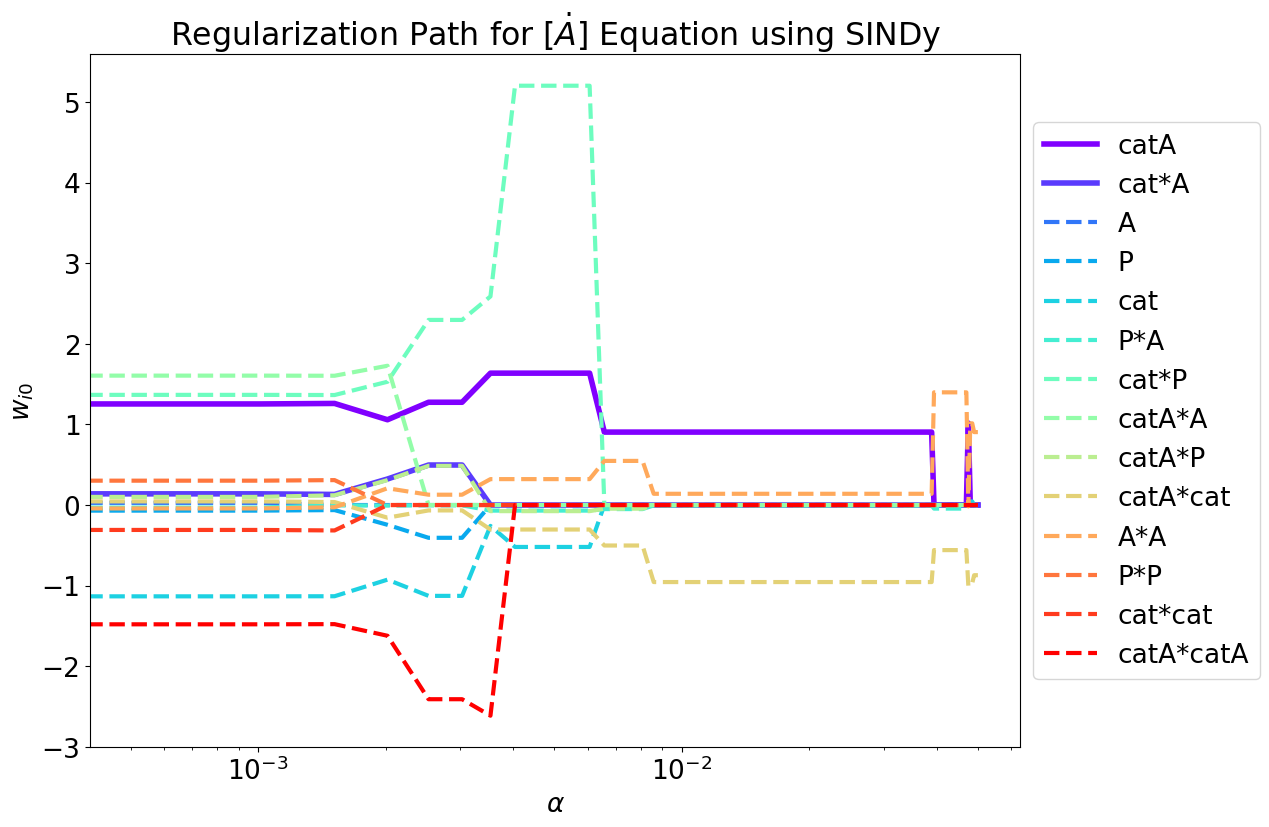

In [58]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $[\dot{A}]$ Equation using SINDy")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]$ Equation using SINDy')

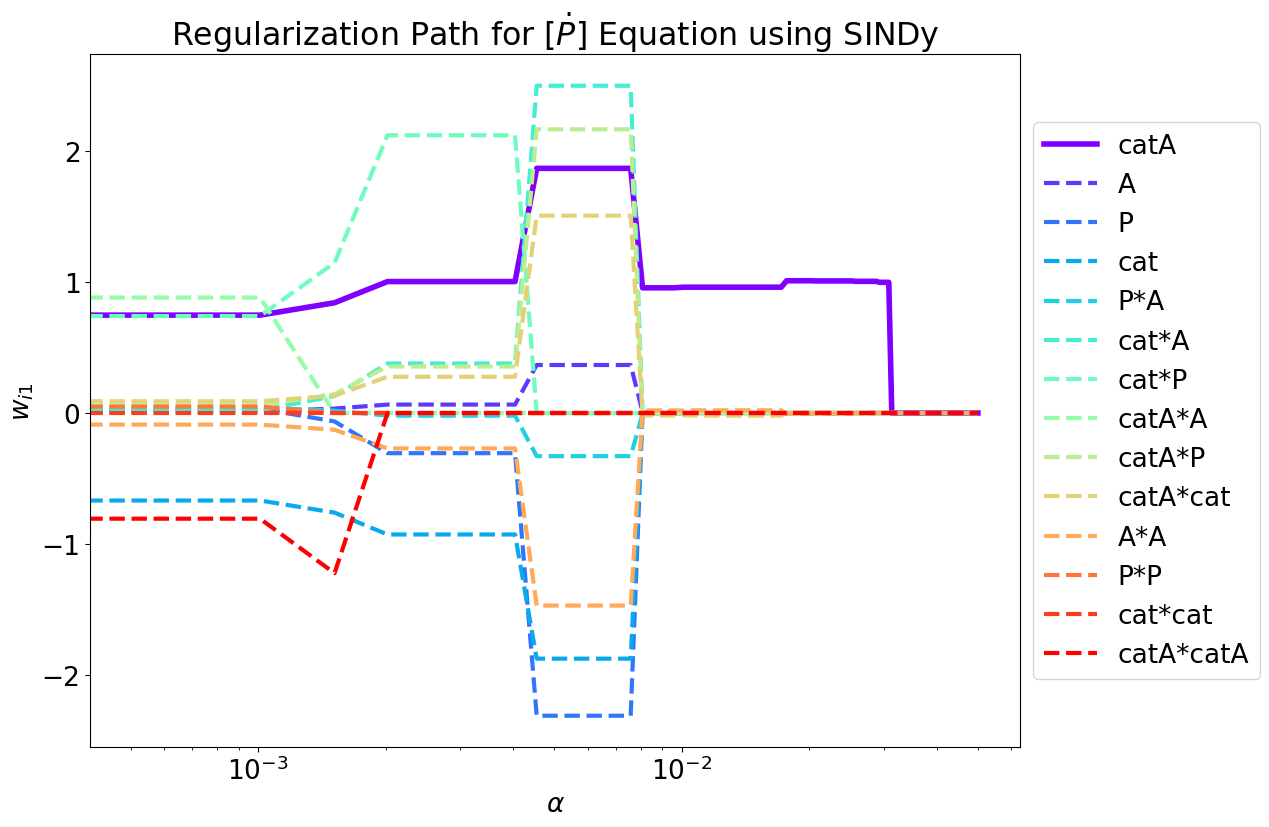

In [59]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $[\dot{P}]$ Equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ Equation using SINDy')

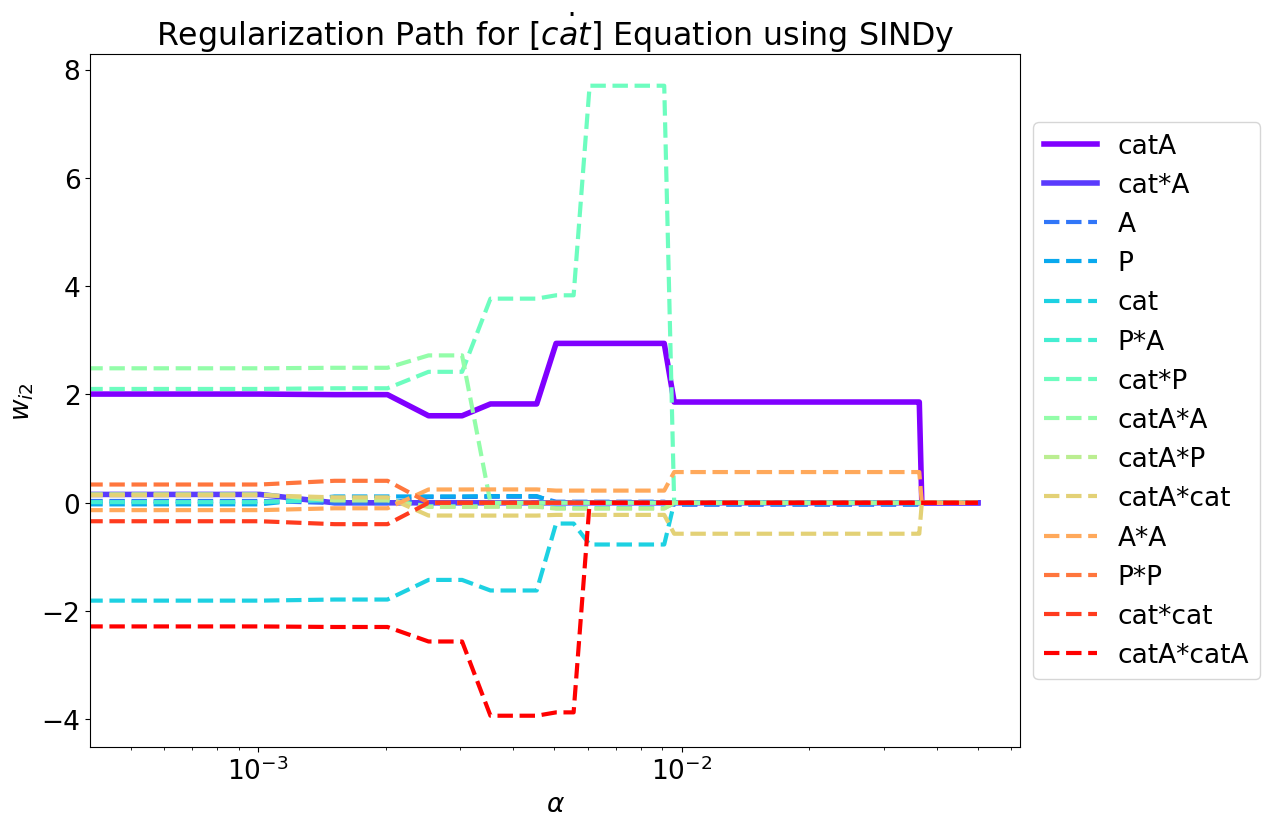

In [60]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $[\dot{cat}]$ Equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ Equation using SINDy')

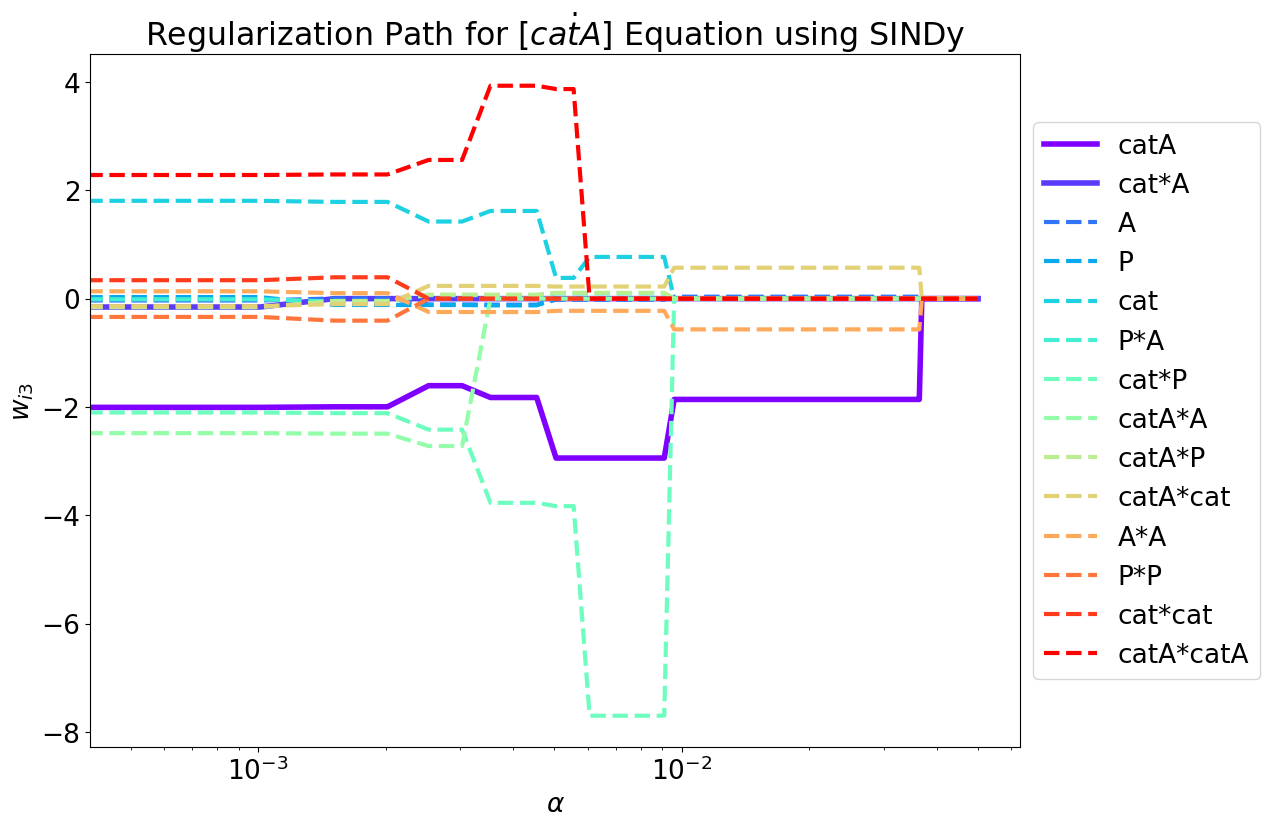

In [61]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $[\dot{catA}]$ Equation using SINDy")

In [62]:
W_sindy_arr = []
alphas = np.linspace(0, 0.2, 200)
W_ridge_arr = []
for alph in alphas: 
    opt = ps.STLSQ(threshold = 0.015, alpha=alph) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

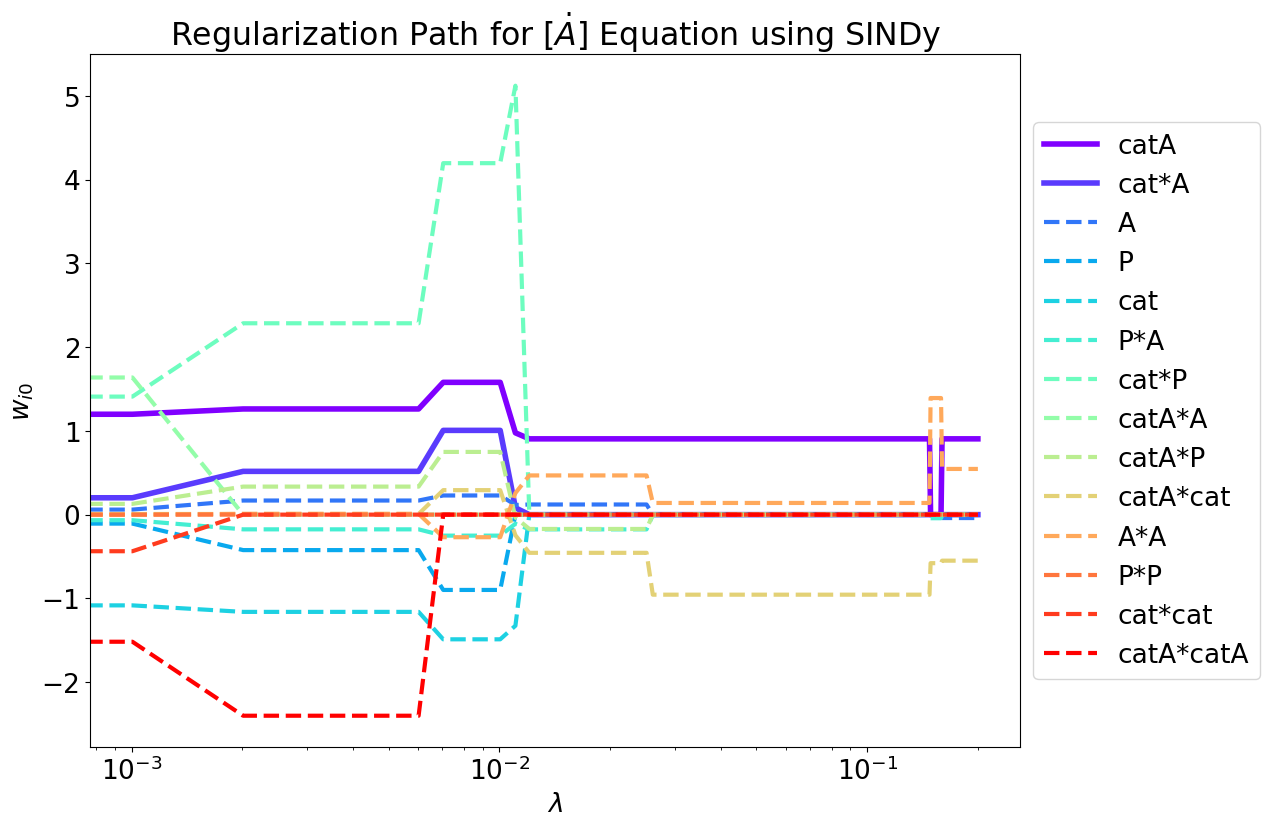

In [63]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $[\dot{A}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

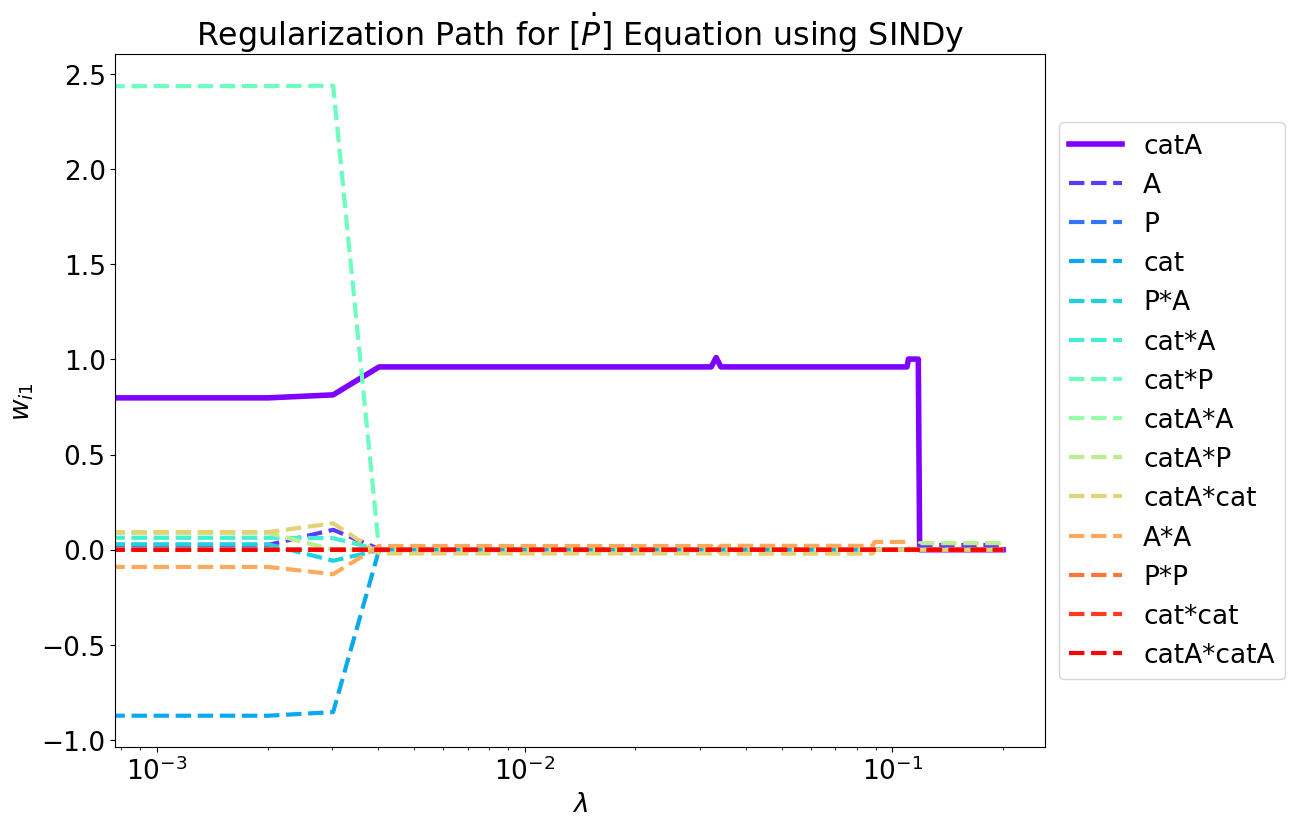

In [64]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $[\dot{P}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

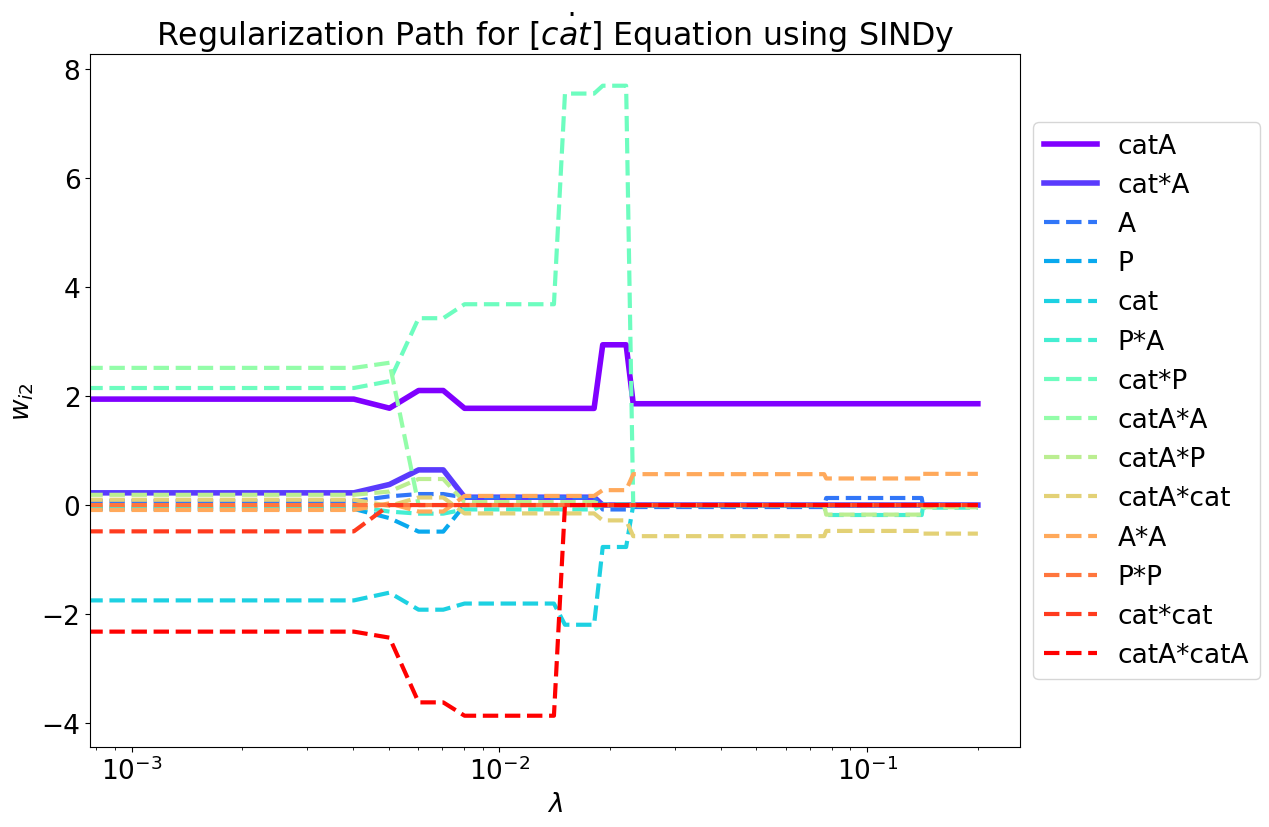

In [65]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $[\dot{cat}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

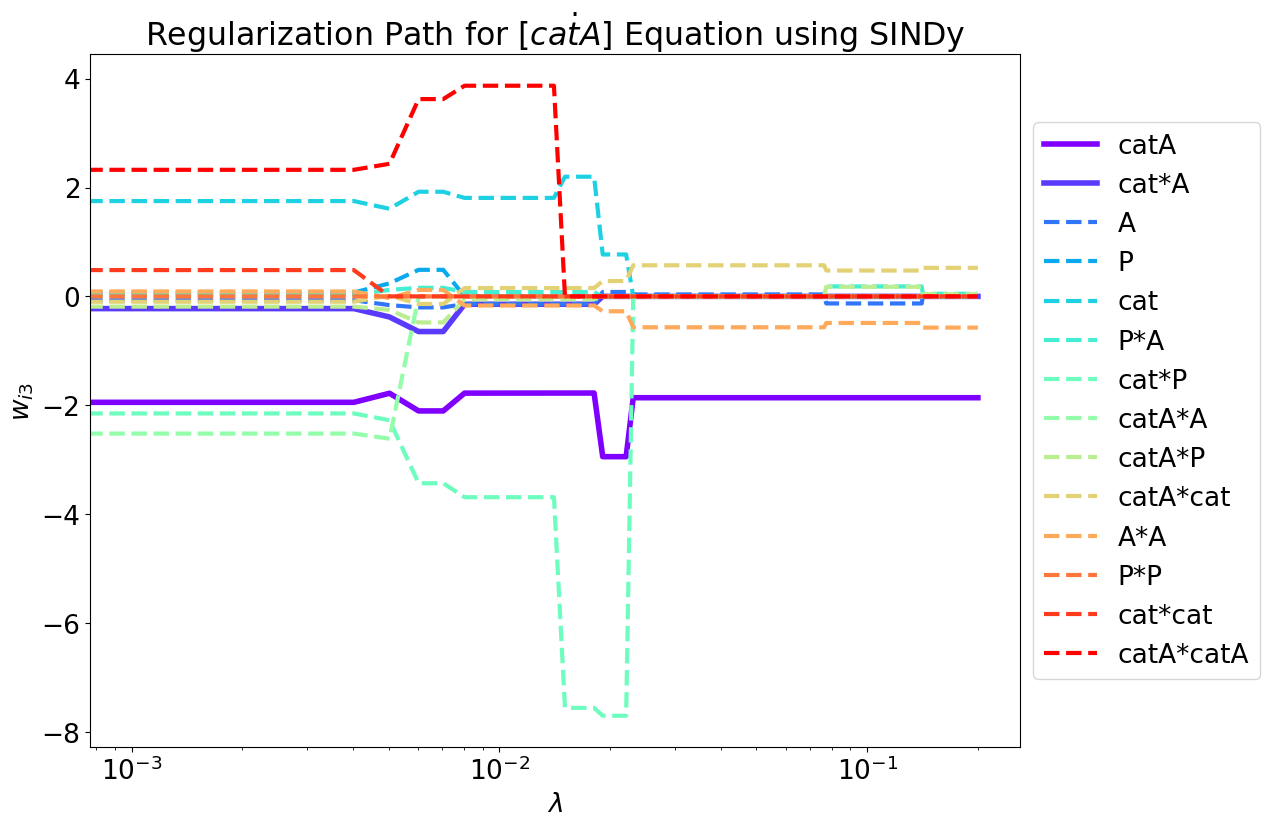

In [66]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $[\dot{catA}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

In [67]:
opt = ps.STLSQ(threshold = 0.05, alpha=0.01) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()

(A)' = 1.006 catA + -1.005 A*cat
(P)' = 1.009 catA + -0.002 A*cat + -0.008 A*catA
(cat)' = 2.025 catA + -1.006 A*cat + -0.025 A*catA
(catA)' = -2.025 catA + 1.006 A*cat + 0.025 A*catA


In [68]:
mechanisms.print_equation(labels, W_sindy, rtol)

+1.01[catA]-1.00[catA*cat]
______
+1.01[catA]-0.00[catA*cat]-0.01[A*A]
______
+2.03[catA]-1.01[catA*cat]-0.02[A*A]
______
-2.03[catA]+1.01[catA*cat]+0.02[A*A]
______
sparsity: 11


11

In [69]:
_, er_w = mechanisms.get_residual(W_sindy, W0)

absolute residual 2.4573437022382594
relative residual 0.6745992317238062
